In [1]:
import h5py
import glob
import numpy as np
import pylab as pl
from scipy.integrate import odeint
from scipy.interpolate import splrep, splev

%matplotlib inline

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8    
pl.rcParams['xtick.minor.size'] = 4    
pl.rcParams['xtick.major.pad']  = 8    
pl.rcParams['xtick.minor.pad']  = 8    
pl.rcParams['xtick.color']      = 'k'    
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'   

pl.rcParams['ytick.major.size'] = 8    
pl.rcParams['ytick.minor.size'] = 4    
pl.rcParams['ytick.major.pad']  = 8    
pl.rcParams['ytick.minor.pad']  = 8    
pl.rcParams['ytick.color']      = 'k'    
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [15]:
from scipy.optimize import root

N = 4096
NGhost = 4
CONDUCTION = 1

X1Start = -.5
X1End   = 1.5

# Inputs for obtaining the Rankine-Hugoniot jump conditions

rhoLeft   = 1.
uLeft     = 1.
u1Left    = 1.
amplitude = 100.
nTrials   = 100
tol       = 1e-5 # Right solution must be different than the left solution by atleast tol.

# Inputs for shock integration
kappa    = 0.1
eta      = 0.1
tau      = 0.1
Gamma    = 4./3
B1       = .00001
B2       = 0.
B3       = 0.

dx1 = (X1End - X1Start)/N
i   = np.arange(0, N, 1)
x   = X1Start + (i + 0.5)*dx1

In [16]:
# First get the left and right ideal fluid states:

def delta(mu, nu):
    if (mu==nu):
        return 1
    else:
        return 0

def TUpDownIdeal(mu, nu, Y):
    rho = Y[0]
    u   = Y[1]
    u1  = Y[2]

    P   = (Gamma - 1)*u

    gamma = np.sqrt(1 + u1*u1)
    ucon  = [gamma, u1, 0, 0]
    ucov  = [-gamma, u1, 0, 0]
    
    bcon0 = B1*ucov[1] + B2*ucov[2] + B3*ucov[3]
    bcon1 = (B1 + bcon0*ucon[1])/ucon[0]
    bcon2 = (B2 + bcon0*ucon[2])/ucon[0]
    bcon3 = (B3 + bcon0*ucon[3])/ucon[0]
    
    bcon = [bcon0, bcon1, bcon2, bcon3]
    bcov = [-bcon0, bcon1, bcon2, bcon3]
    bsqr = bcon[0]*bcov[0] + bcon[1]*bcov[1] + bcon[2]*bcov[2] + bcon[3]*bcov[3]

    ans  =   (rho + u + P + bsqr)*ucon[mu]*ucov[nu] + (P + bsqr/2.)*delta(mu, nu) - bcon[mu]*bcov[nu]

    return ans

def jumpConditions(YRight, YLeft):
    rhoLeft  = YLeft[0]
    u1Left   = YLeft[2]

    rhoRight = YRight[0]
    u1Right  = YRight[2]    
    
    Eqn_rho = rhoLeft*u1Left            - rhoRight*u1Right
    Eqn_u   = TUpDownIdeal(1, 0, YLeft) - TUpDownIdeal(1, 0, YRight)
    Eqn_u1  = TUpDownIdeal(1, 1, YLeft) - TUpDownIdeal(1, 1, YRight)

    return [Eqn_rho, Eqn_u, Eqn_u1]

solnLeftIdeal  = np.array([rhoLeft, uLeft, u1Left])

for n in xrange(nTrials): 
    solnRightIdeal = amplitude*np.random.rand(3)
    soln   = root(jumpConditions, solnRightIdeal, args=(solnLeftIdeal))
    solnRightIdeal = np.array(soln.x)
    diff = sum(solnRightIdeal - solnLeftIdeal)
    if ((diff > tol) and soln.message=='The solution converged.'):
        break

print "Number of trials = ", n+1
print "Left solution    = ", solnLeftIdeal
print "Right solution   = ", soln.x

solnRightIdeal = np.array(soln.x)
rhoRight = solnRightIdeal[0]
uRight   = solnRightIdeal[1]
u1Right  = solnRightIdeal[2]

Number of trials =  5
Left solution    =  [ 1.  1.  1.]
Right solution   =  [ 3.08312999  4.94577705  0.32434571]


In [17]:
def residual(Y):
    rhoGuess = Y[:N];      rhoGuessLeft = Y[0];   rhoGuessRight = Y[N-1]
    uGuess   = Y[N:2*N];   uGuessLeft   = Y[N];   uGuessRight   = Y[2*N-1]
    u1Guess  = Y[2*N:3*N]; u1GuessLeft  = Y[2*N]; u1GuessRight  = Y[3*N-1]
    
    rho = np.concatenate([rhoGuessLeft*np.ones(NGhost), rhoGuess, rhoGuessRight*np.ones(NGhost)])
    u   = np.concatenate([uGuessLeft  *np.ones(NGhost), uGuess,   uGuessRight  *np.ones(NGhost)])
    u1  = np.concatenate([u1GuessLeft *np.ones(NGhost), u1Guess,  u1GuessRight *np.ones(NGhost)])
            
    P     = (Gamma - 1.)*u
    T     = P/rho
    cs    = (Gamma*P/(rho + Gamma*u))**0.5
    eta   = 3. * rho * cs**2. * tau
    kappa = 5. * rho * cs**2. * tau

    b1 = tau/(kappa*T)
    b2 = tau/(2.*eta)

    dPGuess = Y[3*N:4*N]; dPGuessLeft = Y[3*N]; dPGuessRight = Y[4*N-1]
    dP = np.concatenate([dPGuessLeft*np.ones(NGhost), dPGuess, dPGuessRight*np.ones(NGhost)])
    
    if (CONDUCTION):
        qGuess = Y[4*N:5*N]; qGuessLeft = Y[4*N]; qGuessRight = Y[5*N-1]
        q = np.concatenate([qGuessLeft*np.ones(NGhost), qGuess, qGuessRight*np.ones(NGhost)])
    else:
        q = 0.

    gamma = np.sqrt(1. + u1*u1)
    ucon  = [ gamma, u1, 0., 0.]
    ucov  = [-gamma, u1, 0., 0.]
    
    coeffs = -np.array([1./280., -4./105., 1./5., -4./5., 0., 4./5., -1./5., 4./105., -1./280.])

    ducon_dx1 = [np.convolve(ucon[0], coeffs, 'same')/dx1, 
                 np.convolve(ucon[1], coeffs, 'same')/dx1, 0., 0.]
    
    ducov_dx1 = [-ducon_dx1[0], ducon_dx1[1], 0., 0.]
    
    bcon0 = B1*ucov[1] + B2*ucov[2] + B3*ucov[3]
    bcon1 = (B1 + bcon0*ucon[1])/ucon[0]
    bcon2 = (B2 + bcon0*ucon[2])/ucon[0]
    bcon3 = (B3 + bcon0*ucon[3])/ucon[0]
    
    bcon = [ bcon0, bcon1, bcon2, bcon3]
    bcov = [-bcon0, bcon1, bcon2, bcon3]
    bsqr = bcon[0]*bcov[0] + bcon[1]*bcov[1] + bcon[2]*bcov[2] + bcon[3]*bcov[3]
    
    TUpDown = np.zeros([4, 4, N + 2*NGhost])
    for mu in xrange(4):
        for nu in xrange(4):
            TUpDown[mu, nu, :] = \
             (rho + u + P + bsqr)*ucon[mu]*ucov[nu] + (P + 0.5*bsqr)*delta(mu, nu) - bcon[mu]*bcov[nu]\
            - dP/bsqr*(bcon[mu]*bcov[nu]) + dP/3.*(ucon[mu]*ucov[nu] + delta(mu, nu)) \
            + q/np.sqrt(bsqr) * (bcon[mu]*ucov[nu] + ucon[mu]*bcov[nu])
               
    dP_relaxed = 0.
    for nu in xrange(4):
        dP_relaxed = dP_relaxed + 3.*eta/bsqr * (bcon[nu]*bcon[1]*ducov_dx1[nu] )

    dP_relaxed = dP_relaxed - eta*ducon_dx1[1]
    
    dP_dx1 = np.convolve(dP, coeffs, 'same')/dx1
        
    Eqn_rho = rho*u1           - rhoLeft*u1Left
    Eqn_u   = TUpDown[1, 0, :] - TUpDownIdeal(1, 0, [rhoLeft, uLeft, u1Left])
    Eqn_u1  = TUpDown[1, 1, :] - TUpDownIdeal(1, 1, [rhoLeft, uLeft, u1Left])
        
    Eqn_dP  = ucon[1]*dP_dx1 + (dP - dP_relaxed)/tau + dP*T/(2.*b2)*np.convolve(b2*ucon[1]/T, coeffs, 'same')/dx1
    #dD_dx1 = np.convolve(dP * (tau/(eta*P))**0.5, coeffs, 'same')/dx1
    #dD     = dP * (tau/(eta*P))**0.5
    #dD_relaxed = dP_relaxed * (tau/(eta*P))**0.5
    #Eqn_dP = ucon[1]*dD_dx1 + (dD - dD_relaxed)/tau
    
    #dP_scaled = dP * (tau / (eta * T))**0.5
    #dP_scaled_relaxed = dP_relaxed * (tau / (eta * T))**0.5
    
    #Eqn_dP = np.convolve(ucon[1]*dP_scaled, coeffs, 'same')/dx1 + (dP_scaled - dP_scaled_relaxed)/tau \
    #        - 0.5*dP_scaled*np.convolve(ucon[1], coeffs, 'same')/dx1
    
    acon = [ucon[1]*ducon_dx1[0], ucon[1]*ducon_dx1[1], ucon[1]*ducon_dx1[2], ucon[1]*ducon_dx1[3]]
    acov = [-acon[0], acon[1], acon[2], acon[3]]
    dT_dx1 = np.convolve(T, coeffs, 'same')/dx1

    def qconEckart(mu):
        gcon = np.array([[-1., 0., 0., 0.], \
                         [ 0., 1., 0., 0.], \
                         [ 0., 0., 1., 0.], \
                         [ 0., 0., 0., 1.] \
                        ])        
        return -kappa*(ucon[mu]*ucon[0] + gcon[mu, 0])*(T*acov[0]) \
               -kappa*(ucon[mu]*ucon[1] + gcon[mu, 1])*(dT_dx1 + T*acov[1]) \
               -kappa*(ucon[mu]*ucon[2] + gcon[mu, 2])*(T*acov[2])
            
    q_relaxed = (bcov[0]*qconEckart(0) + bcov[1]*qconEckart(1) + bcov[2]*qconEckart(2) + bcov[3]*qconEckart(3) )/np.sqrt(bsqr)
    
    dq_dx1 = np.convolve(q, coeffs, 'same')/dx1
        
    if (CONDUCTION):
        Eqn_q  = ucon[1]*dq_dx1  + (q  - q_relaxed)/tau + q*T/(2.*b1)*np.convolve(b1*ucon[1]/T, coeffs, 'same')/dx1

        return np.concatenate([Eqn_rho[NGhost:-NGhost], Eqn_u[NGhost:-NGhost], Eqn_u1[NGhost:-NGhost], \
                               Eqn_dP[NGhost:-NGhost], Eqn_q[NGhost:-NGhost]])
    else:
        return np.concatenate([Eqn_rho[NGhost:-NGhost], Eqn_u[NGhost:-NGhost], Eqn_u1[NGhost:-NGhost], \
                               Eqn_dP[NGhost:-NGhost]])


def jacobian(Y):
    eps = 4e-6
    e   = np.diag(np.ones(Y.size))
    jac = np.zeros([Y.size, Y.size])

    for row in xrange(Y.size):
        residualPlusEps  = residual(Y + eps*e[row])
        residualMinusEps = residual(Y - eps*e[row])

        for column in xrange(Y.size):
            jac[column, row] = (residualPlusEps[column] - residualMinusEps[column])/(2.*eps)

    return jac

In [18]:
smoothness = 10.
rhoGuess = rhoLeft + 0.5*(rhoRight - rhoLeft)*(np.tanh(x*smoothness) + 1.)
uGuess   = uLeft   + 0.5*(uRight   - uLeft)  *(np.tanh(x*smoothness) + 1.)
u1Guess  = u1Left  + 0.5*(u1Right  - u1Left) *(np.tanh((x)*smoothness) + 1.)
dPGuess  = np.zeros(N)
qGuess   = np.zeros(N)
if (CONDUCTION):
    guess = np.concatenate([rhoGuess, uGuess, u1Guess, dPGuess, qGuess])
else:
    guess = np.concatenate([rhoGuess, uGuess, u1Guess, dPGuess])

newGuess = guess.copy()

for nonLinearIter in xrange(50):
    print "Nonlinear iter = ", nonLinearIter
    
    jac = jacobian(newGuess)
    jacInverse = np.linalg.inv(jac)

    solRoot = root(residual, newGuess, method='krylov', \
                   options={'disp': True, 'maxiter': 1, \
                            'fatol':5e-14, 'jac_options':{'inner_M' : jacInverse} })
    rhoRoot = solRoot.x[:N]
    uRoot   = solRoot.x[N:2*N]
    u1Root  = solRoot.x[2*N:3*N]
    dPRoot  = solRoot.x[3*N:4*N]
    if (CONDUCTION):
        qRoot = solRoot.x[4*N:5*N]
    
    np.savetxt('shock_soln_xCoords.txt', x,       delimiter="\n")
    np.savetxt('shock_soln_rho.txt',     rhoRoot, delimiter="\n")
    np.savetxt('shock_soln_u.txt',       uRoot,   delimiter="\n")
    np.savetxt('shock_soln_u1.txt',      u1Root,  delimiter="\n")
    np.savetxt('shock_soln_dP.txt',      dPRoot,  delimiter="\n")
    np.savetxt('shock_soln_q.txt',       qRoot,   delimiter="\n")
    
    newGuess = solRoot.x.copy()

Nonlinear iter =  0
0:  |F(x)| = 138.048; step 0.117219; tol 0.681372
Nonlinear iter =  1
0:  |F(x)| = 24.6786; step 1; tol 0.0287623
Nonlinear iter =  2
0:  |F(x)| = 23.7747; step 0.0349413; tol 0.835281
Nonlinear iter =  3
0:  |F(x)| = 23.7622; step 0.000526173; tol 0.899052
Nonlinear iter =  4
0:  |F(x)| = 23.6701; step 0.00380871; tol 0.893033
Nonlinear iter =  5
0:  |F(x)| = 6.71618; step 1; tol 0.0724584
Nonlinear iter =  6
0:  |F(x)| = 6.50093; step 0.0326243; tol 0.843235
Nonlinear iter =  7
0:  |F(x)| = 4.17658; step 0.368992; tol 0.371479
Nonlinear iter =  8
0:  |F(x)| = 1.06589; step 1; tol 0.0586175
Nonlinear iter =  9
0:  |F(x)| = 0.25067; step 1; tol 0.049776
Nonlinear iter =  10
0:  |F(x)| = 0.0446288; step 1; tol 0.0285278
Nonlinear iter =  11
0:  |F(x)| = 0.00237841; step 1; tol 0.00255615
Nonlinear iter =  12
0:  |F(x)| = 7.31287e-06; step 1; tol 8.50834e-06
Nonlinear iter =  13
0:  |F(x)| = 7.26339e-06; step 0.00709409; tol 0.887861
Nonlinear iter =  14
0:  |F(x)| = 

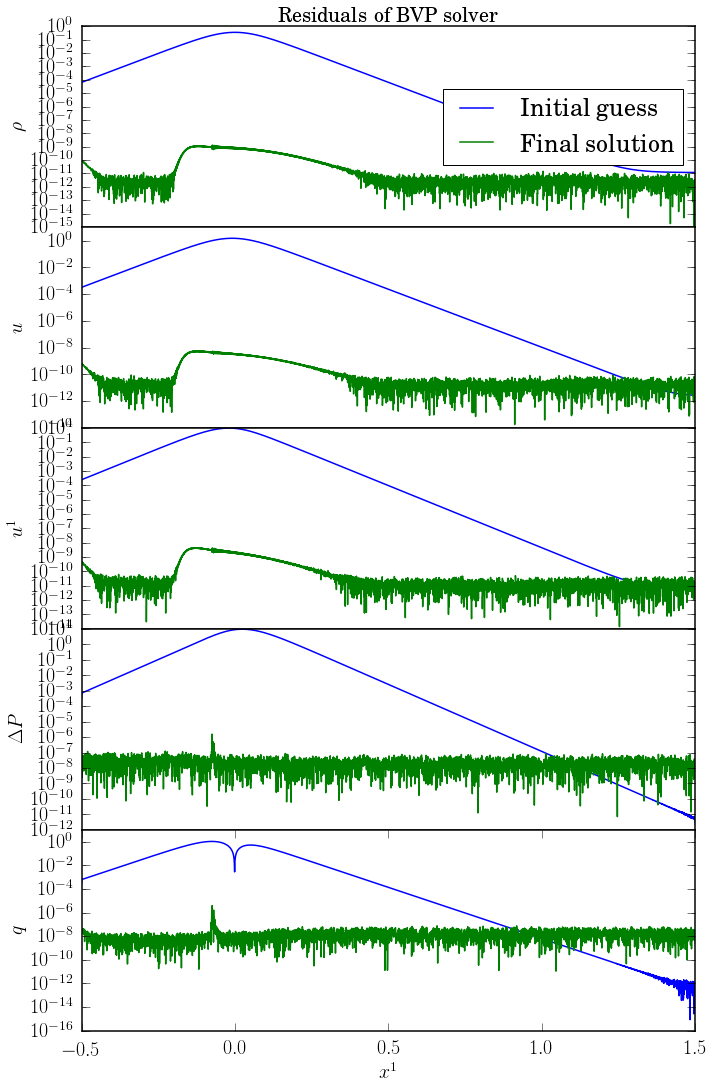

In [19]:
fig, axes = pl.subplots(5, 1, figsize=(11, 18))
pl.subplots_adjust(hspace=0.001)

axes[0].set_title('Residuals of BVP solver')

axes[0].semilogy(x, abs(residual(guess)[:N]))
axes[0].semilogy(x, abs(residual(solRoot.x)[:N]))
axes[0].set_xticks([])
axes[0].legend(['Initial guess', 'Final solution'], loc='center right')
axes[0].set_ylabel('$\\rho$')

axes[1].semilogy(x, abs(residual(guess)[N:2*N]))
axes[1].semilogy(x, abs(residual(solRoot.x)[N:2*N]))
axes[1].set_xticks([])
axes[1].set_ylabel('$u$')

axes[2].semilogy(x, abs(residual(guess)[2*N:3*N]))
axes[2].semilogy(x, abs(residual(solRoot.x)[2*N:3*N]))
axes[2].set_xticks([])
axes[2].set_ylabel('$u^1$')

axes[3].semilogy(x, abs(residual(guess)[3*N:4*N]))
axes[3].semilogy(x, abs(residual(solRoot.x)[3*N:4*N]))
axes[3].set_xticks([])
axes[3].set_ylabel('$\Delta P$')

axes[4].semilogy(x, abs(residual(guess)[4*N:5*N]))
axes[4].semilogy(x, abs(residual(solRoot.x)[4*N:5*N]))
axes[4].set_ylabel('$q$')
axes[4].set_xlabel('$x^1$')

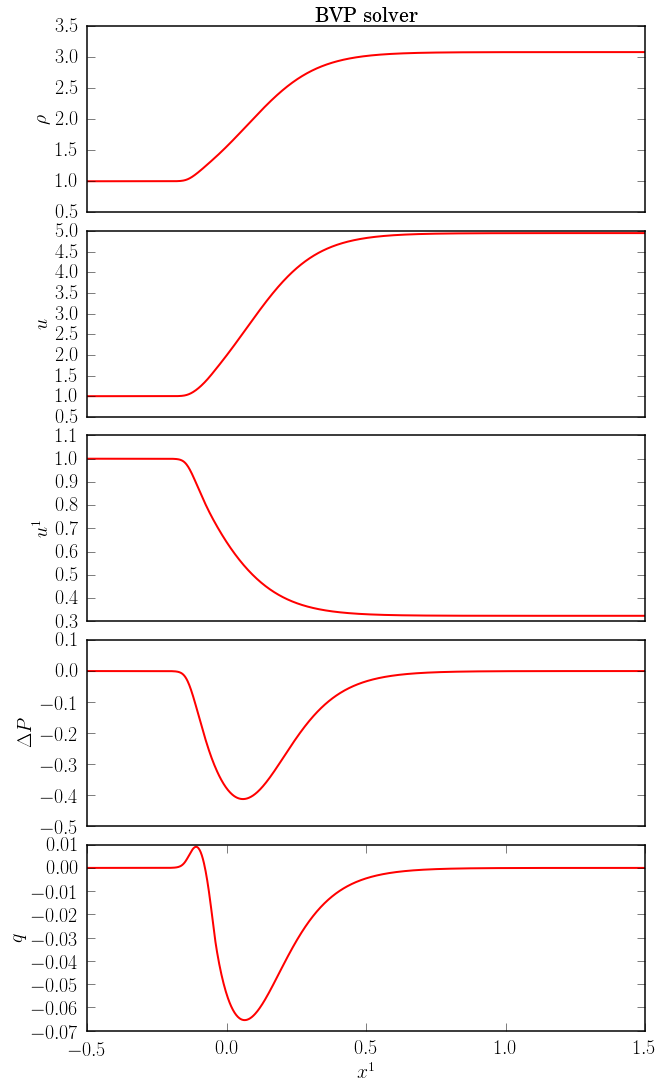

In [7]:
fig, axes = pl.subplots(5, 1, figsize=(10, 18))
pl.subplots_adjust(hspace=0.1)

axes[0].set_title('BVP solver')

axes[0].plot(x, rhoRoot, color='red', lw=2)
axes[0].set_xticks([])
#axes[0].legend(['$\mathtt{grim}$', 'BVP solver'], loc='center right')
axes[0].set_ylabel('$\\rho$')

axes[1].plot(x, uRoot, color='red', lw=2)
axes[1].set_xticks([])
axes[1].set_ylabel('$u$')

axes[2].plot(x, u1Root, color='red', lw=2)
axes[2].set_xticks([])
axes[2].set_ylabel('$u^1$')

axes[3].plot(x, dPRoot, color='red', lw=2)
axes[3].set_xticks([])
axes[3].set_ylabel('$\Delta P$')

axes[4].plot(x, qRoot, color='red', lw=2)
axes[4].set_ylabel('$q$')
axes[4].set_xlabel('$x^1$')